# Обучение модели YOLO для детектирования ROI

In [19]:
import pandas as pd
import json
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import cv2

## Загрузка датасета

In [20]:
train_df = pd.read_excel(r'train/train.xlsx')
# Оставляем только класс с наличием патологии, т.к.
# только он содержит annotation
train_df = train_df[train_df['pathology'] == 1]

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 262


,Unnamed: 0.1,Unnamed: 0,ID,image_path,annotation_path_label,pathology
0,0,0,image_393.jpg,train/images/image_393.jpg,train/annotation/annotation_393.json,1
1,1,1,image_326.jpg,train/images/image_326.jpg,train/annotation/annotation_326.json,1
2,2,2,image_290.jpg,train/images/image_290.jpg,train/annotation/annotation_290.json,1
3,3,3,image_206.jpg,train/images/image_206.jpg,train/annotation/annotation_206.json,1
5,5,5,image_252.jpg,train/images/image_252.jpg,train/annotation/annotation_252.json,1


## Визуализация исследования с ROI и центральной точкой

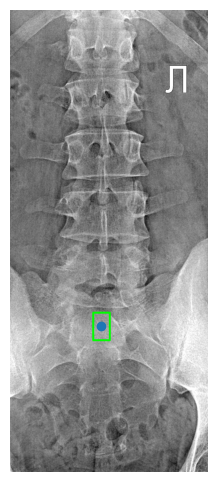

In [21]:
idx = 16

# Загрузка изображения и JSON
image_path = train_df['image_path'][idx]
json_path = train_df['annotation_path_label'][idx]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для корректного отображения
with open(json_path, 'r') as f:
    data = json.load(f)

# Извлечение координат bbox
bbox = data['annotations'][0]['bbox']
x, y, w, h = map(int, bbox)
x_center = x + (w/2)
y_center = y + (h/2)

# Рисование прямоугольника
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)

# Отображение с помощью matplotlib
plt.figure(figsize=(9, 6))
plt.scatter(x_center, y_center)
plt.imshow(image)
plt.axis('off')
plt.show()

## Формируем YOLO датасет

In [22]:
def create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image):
    """
    Функция для формирования данных о ROI для датасета
    Args:
    x_center: Координаты центральной точки по x
    y_center: Координаты центральной точки по y
    w: Ширина ROI
    h: Высота ROI
    w_image: Ширина изображения
    h_image: Высота изображения

    Return:
    Строка в нужном формате
    """
    x_centerY = x_center / w_image
    y_centerY = y_center / h_image
    wY = w / w_image
    hY = h / h_image
    return f'0 {x_centerY} {y_centerY} {wY} {hY}'

# Получаем список из id исследований
id_list = train_df['Unnamed: 0'].to_list()

# Формируем датасет из txt файлов с информацией о ROI
# копируем и переименовываем файлы с изображениями
for idx in id_list:
    image_path = train_df['image_path'][idx]
    json_path = train_df['annotation_path_label'][idx]
    image = cv2.imread(image_path)
    with open(json_path, 'r') as f:
        data = json.load(f)
    x, y, w, h = map(int, bbox)
    x_center = x + (w/2)
    y_center = y + (h/2)
    h_image = image.shape[0]
    w_image = image.shape[1]
    
    # Создаём папки для датасета, если их нет
    if not os.path.isdir("yolo_dataset"):
     os.mkdir("yolo_dataset")
    if not os.path.isdir("yolo_dataset/labels"):
     os.mkdir("yolo_dataset/labels")
    if not os.path.isdir("yolo_dataset/images"):
     os.mkdir("yolo_dataset/images")

    with open(f'yolo_dataset/labels/{idx}.txt', 'w') as f:
        f.write(create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image))

    shutil.copy(train_df['image_path'][idx], os.path.join(f'yolo_dataset/images/{idx}.jpg'))
    

## Разбиение датасета на тренирововочную, валидационную и тестовую выборку

In [23]:
import os
import shutil
import random

# Определяем пути к исходным и целевым директориям
source_dir = 'yolo_dataset'
train_dir = 'yolo_dataset/train'
val_dir = 'yolo_dataset/val'
test_dir = 'yolo_dataset/test'

# Создаем целевые директории, если они не существуют
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'labels'), exist_ok=True)

# Получаем список всех файлов изображений
image_files = [f for f in os.listdir(os.path.join(source_dir, 'images')) if f.endswith('.jpg')]

# Перемешиваем список файлов
random.shuffle(image_files)

# Определяем размеры наборов данных
total_files = len(image_files)
train_size = int(0.7 * total_files)
val_size = int(0.15 * total_files)
test_size = total_files - train_size - val_size

# Разделяем файлы на наборы
train_files = image_files[:train_size]
val_files = image_files[train_size:train_size+val_size]
test_files = image_files[train_size+val_size:]

# Функция для копирования файлов
def copy_files(file_list, target_dir):
    for file in file_list:
        image_src = os.path.join(source_dir, 'images', file)
        label_src = os.path.join(source_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        image_dst = os.path.join(target_dir, 'images', file)
        label_dst = os.path.join(target_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        shutil.copy(image_src, image_dst)
        shutil.copy(label_src, label_dst)

# Копируем файлы в соответствующие директории
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f"Разделение завершено. Тренировочных файлов: {len(train_files)}, Валидационных: {len(val_files)}, Тестовых: {len(test_files)}")

Разделение завершено. Тренировочных файлов: 183, Валидационных: 39, Тестовых: 40


## Обучение модели на архитектуре YOLO8

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')
results = model.train(data=f'yolo_dataset/data.yaml', epochs = 60, imgsz = 320, batch = 10, patience = 6)